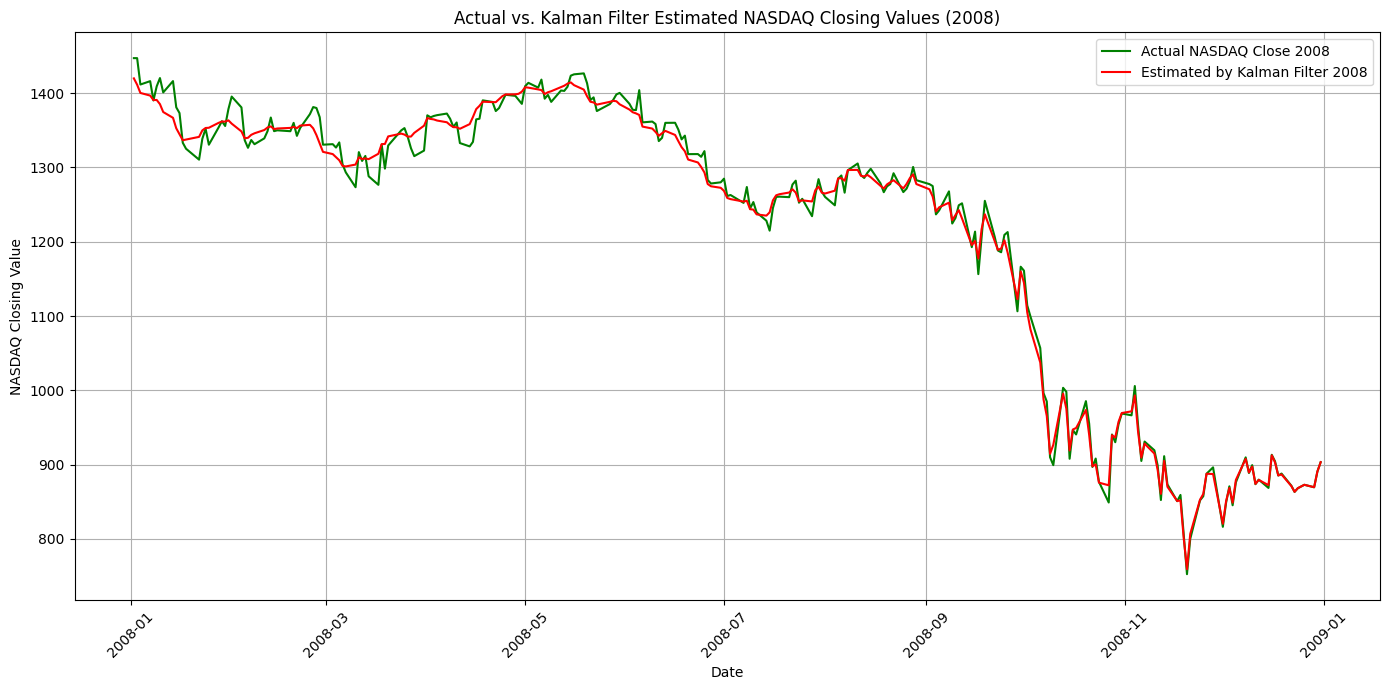

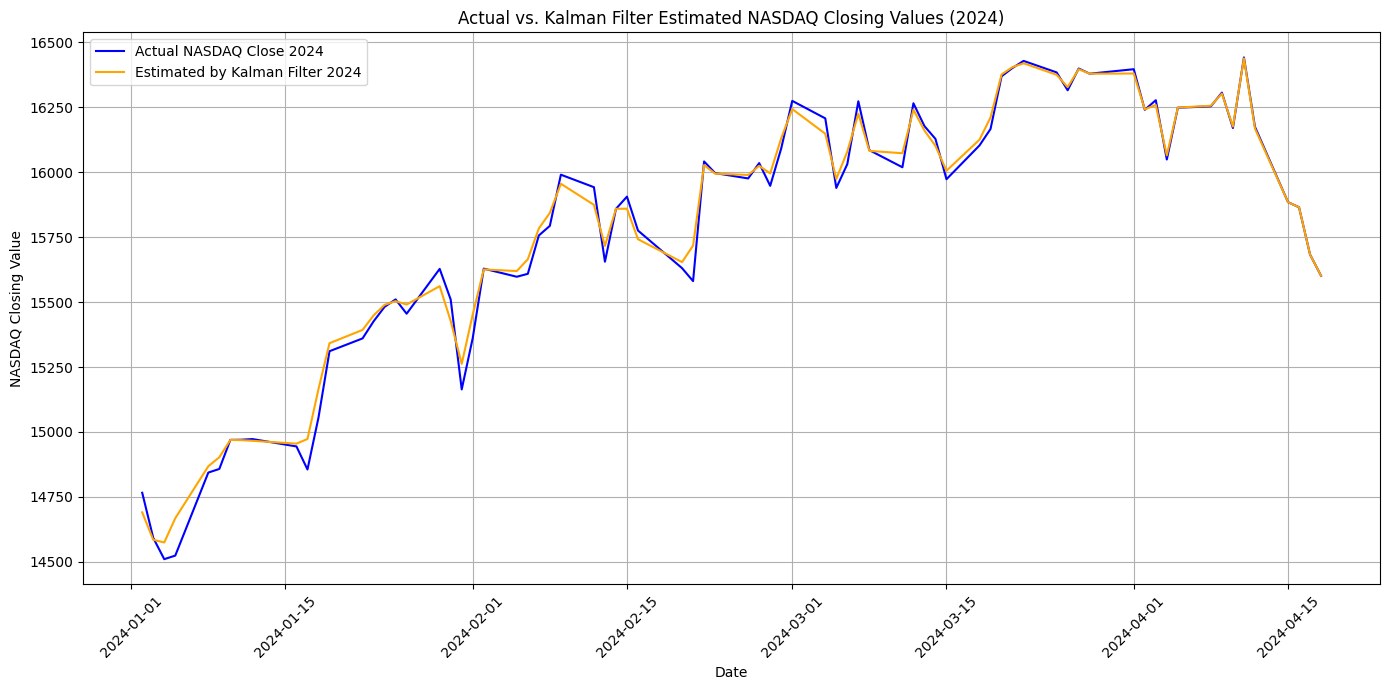

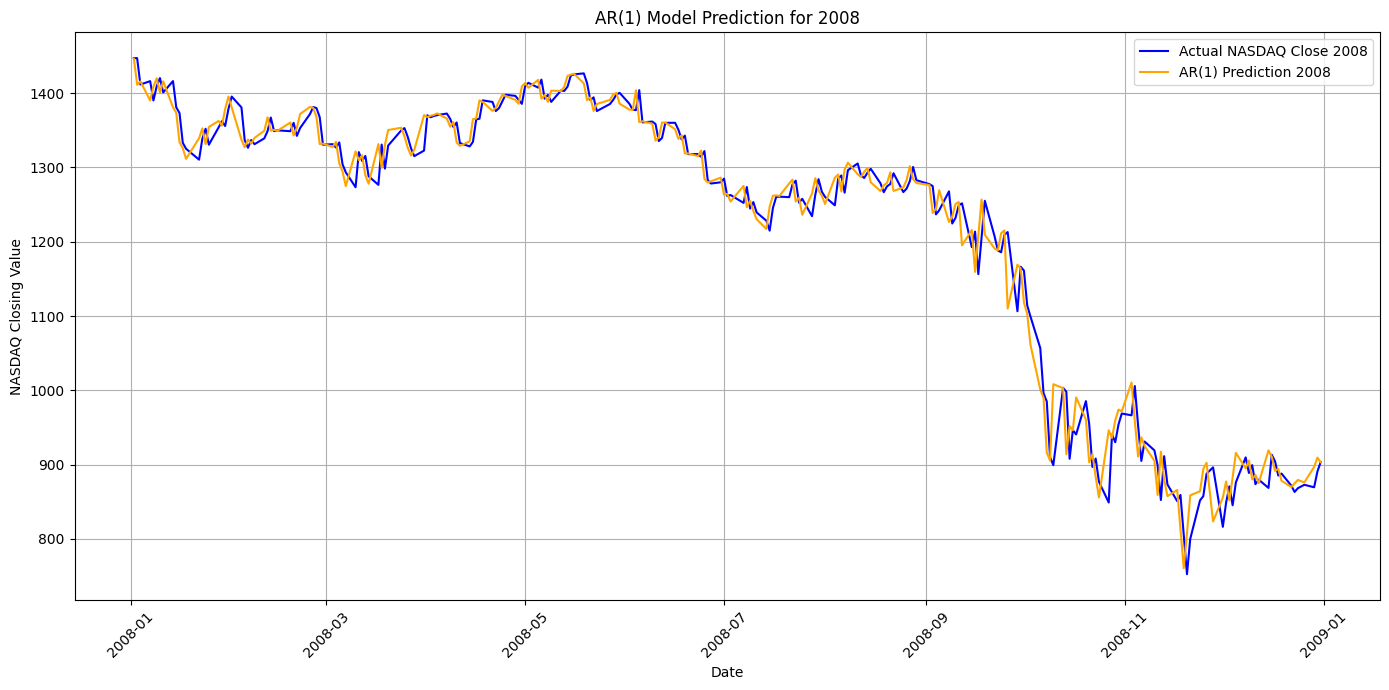

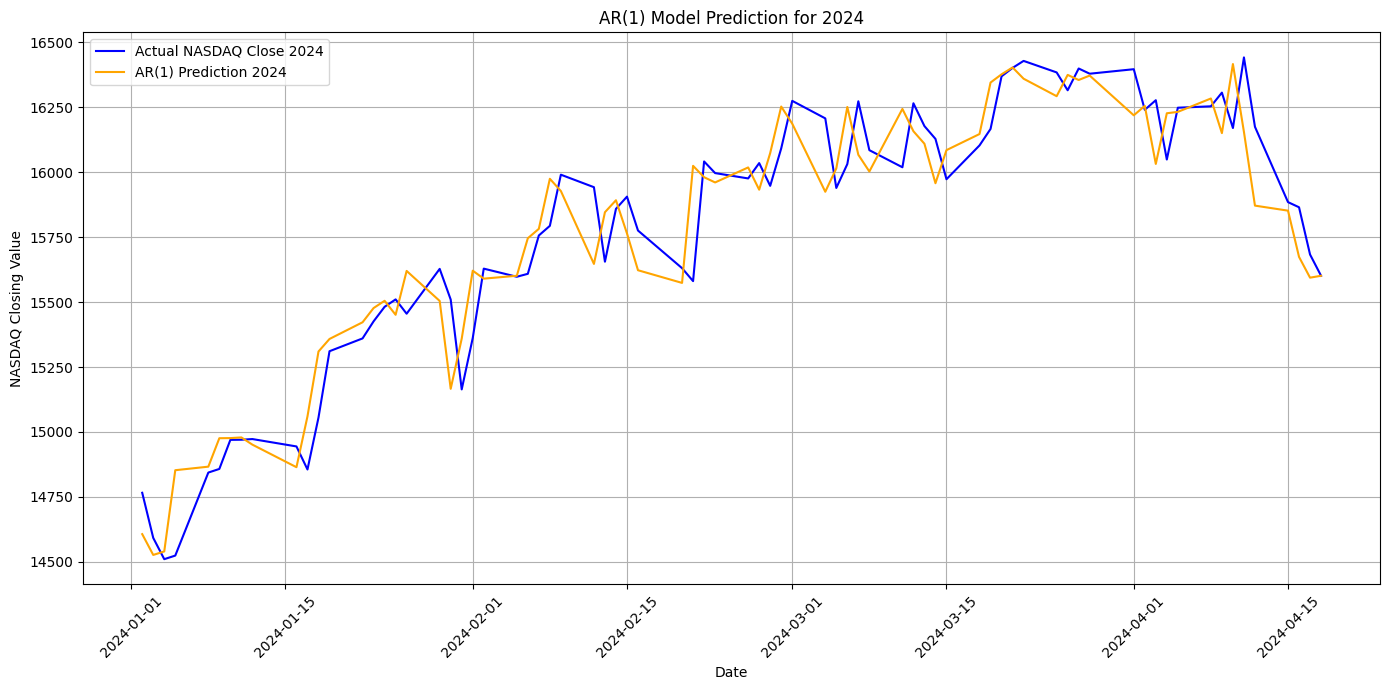

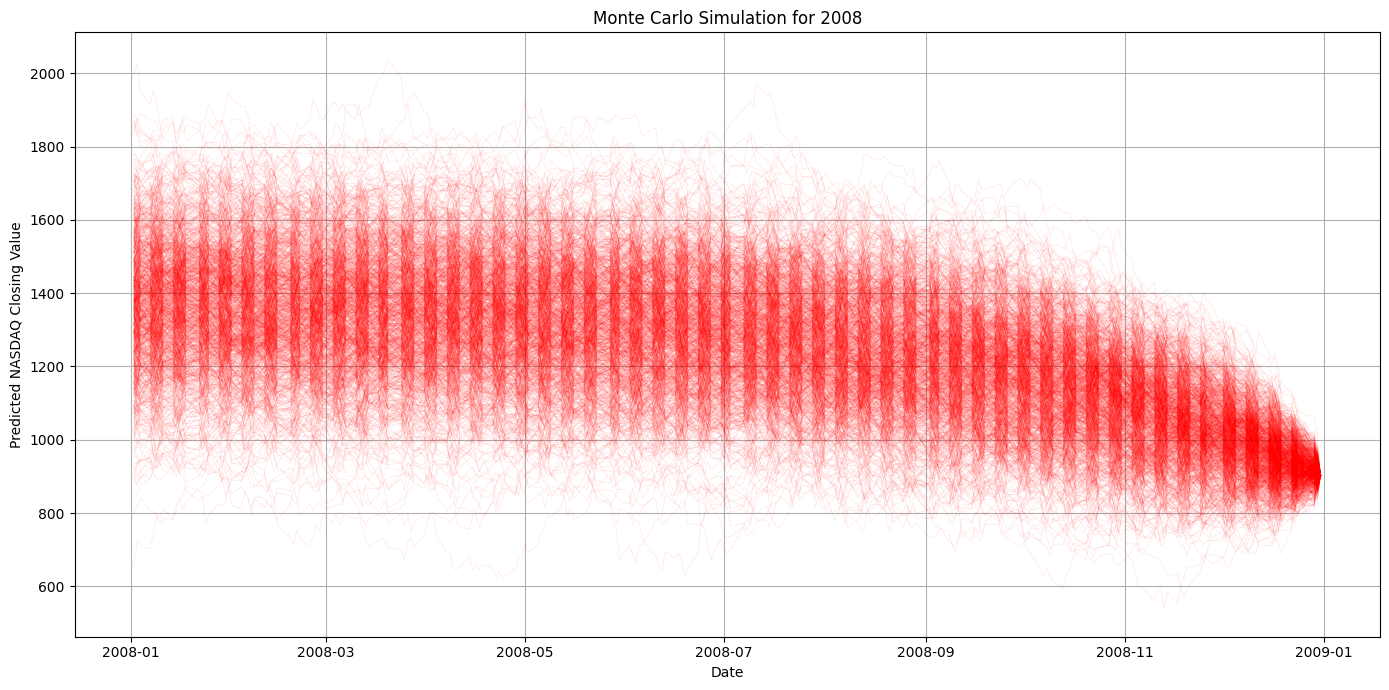

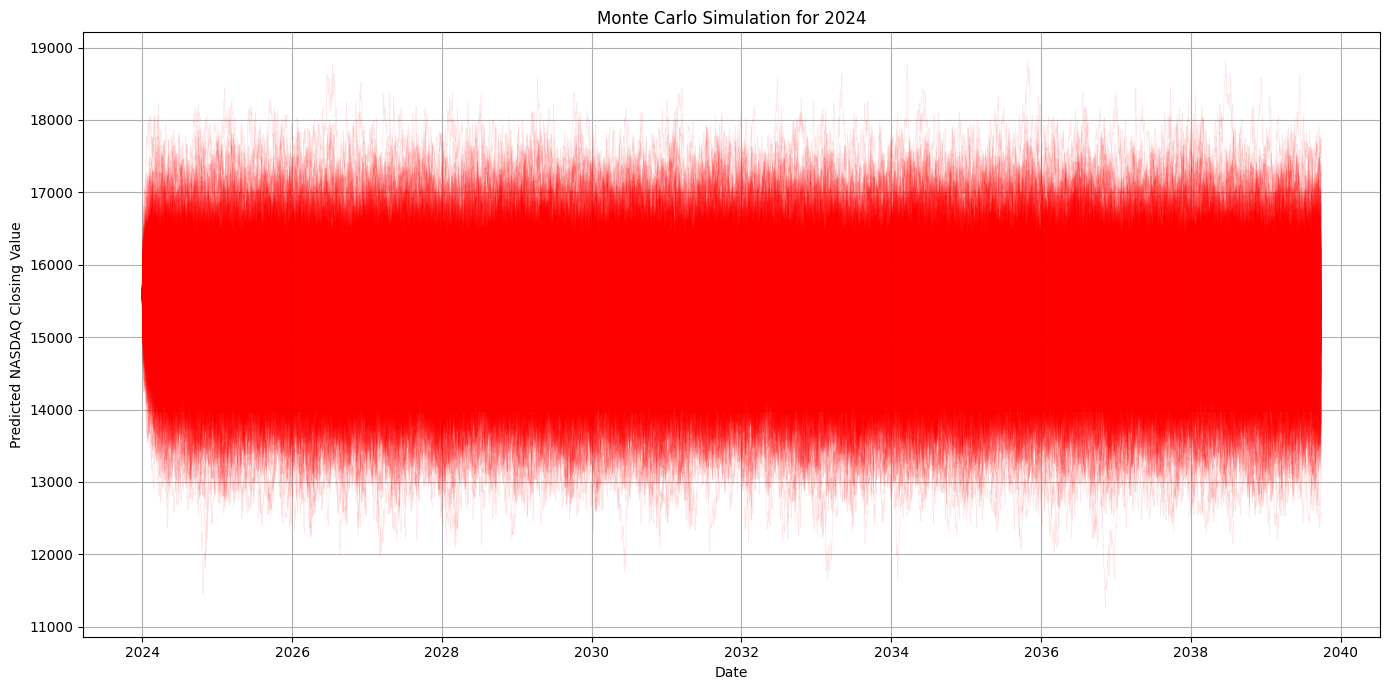

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class AdaptiveKalmanFilter:
    def __init__(self, beta_initial, P_initial, Q_initial, R_initial, adapt_rate=0.01):
        self.beta = beta_initial
        self.P = P_initial
        self.Q = Q_initial
        self.R = R_initial
        self.adapt_rate = adapt_rate

    def update(self, y):
        # Prediction
        beta_predicted = self.beta
        P_predicted = self.P + self.Q

        # Innovation
        innovation = y - beta_predicted
        innovation_variance = P_predicted + self.R

        # Update Q and R adaptively based on innovation
        self.Q = (1 - self.adapt_rate) * self.Q + self.adapt_rate * (innovation ** 2)
        self.R = (1 - self.adapt_rate) * self.R + self.adapt_rate * innovation_variance

        # Kalman Gain
        K = P_predicted / innovation_variance
        self.beta = beta_predicted + K * innovation
        self.P = (1 - K) * P_predicted

        return self.beta

# Load and prepare NASDAQ data for both 2008 and 2024
nasdaq_data = pd.read_csv("NasdaqData.csv")
nasdaq_data['Close'] = nasdaq_data['Close'].str.replace(',', '').astype(float)
nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])
nasdaq_data_2008 = nasdaq_data[nasdaq_data['Date'].dt.year == 2008]

nasdaq_data_2024 = pd.read_csv("Nasdaq2024.csv")
if nasdaq_data_2024['Close/Last'].dtype == object:
    nasdaq_data_2024['Close/Last'] = nasdaq_data_2024['Close/Last'].str.replace(',', '').astype(float)
nasdaq_data_2024['Date'] = pd.to_datetime(nasdaq_data_2024['Date'])

# Initialize and run Kalman Filter for 2008 data
beta_initial_2008 = nasdaq_data_2008['Close'].iloc[0]
kalman_filter_2008 = AdaptiveKalmanFilter(beta_initial_2008, 1.0, 0.0001, 0.001, 0.02)
estimated_betas_2008 = [beta_initial_2008]
for price in nasdaq_data_2008['Close'][1:]:
    estimated_beta = kalman_filter_2008.update(price)
    estimated_betas_2008.append(estimated_beta)

# Plot 2008 Kalman Filter results
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data_2008['Date'], nasdaq_data_2008['Close'], label='Actual NASDAQ Close 2008', color='green')
plt.plot(nasdaq_data_2008['Date'], estimated_betas_2008, label='Estimated by Kalman Filter 2008', color='red')
plt.xlabel('Date')
plt.ylabel('NASDAQ Closing Value')
plt.title('Actual vs. Kalman Filter Estimated NASDAQ Closing Values (2008)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Initialize and run Kalman Filter for 2024 data
beta_initial_2024 = nasdaq_data_2024['Close/Last'].iloc[0]
kalman_filter_2024 = AdaptiveKalmanFilter(beta_initial_2024, 1.0, 0.0001, 0.001, 0.02)
estimated_betas_2024 = [beta_initial_2024]
for price in nasdaq_data_2024['Close/Last'][1:]:
    estimated_beta = kalman_filter_2024.update(price)
    estimated_betas_2024.append(estimated_beta)

# Plot 2024 Kalman Filter results
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data_2024['Date'], nasdaq_data_2024['Close/Last'], label='Actual NASDAQ Close 2024', color='blue')
plt.plot(nasdaq_data_2024['Date'], estimated_betas_2024, label='Estimated by Kalman Filter 2024', color='orange')
plt.xlabel('Date')
plt.ylabel('NASDAQ Closing Value')
plt.title('Actual vs. Kalman Filter Estimated NASDAQ Closing Values (2024)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# AR(1) model for 2008
def fit_ar1(data):
    Y = data[1:]
    X = data[:-1]
    X = np.column_stack([np.ones(len(X)), X])
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    residuals = Y - X @ beta
    sigma2 = np.var(residuals, ddof=2)
    return beta[1], sigma2, beta[0]

ar1_coefficient_2008, noise_variance_2008, intercept_2008 = fit_ar1(nasdaq_data_2008['Close'].values)
X_ar_2008 = [nasdaq_data_2008['Close'].values[0]]
for price in nasdaq_data_2008['Close'].values[:-1]:
    X_ar_2008.append(intercept_2008 + ar1_coefficient_2008 * price)

# Plot AR(1) process for 2008
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data_2008['Date'], nasdaq_data_2008['Close'], label='Actual NASDAQ Close 2008', color='blue')
plt.plot(nasdaq_data_2008['Date'], X_ar_2008, label='AR(1) Prediction 2008', color='orange')
plt.xlabel('Date')
plt.ylabel('NASDAQ Closing Value')
plt.title('AR(1) Model Prediction for 2008')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# AR(1) model for 2024
ar1_coefficient_2024, noise_variance_2024, intercept_2024 = fit_ar1(nasdaq_data_2024['Close/Last'].values)
X_ar_2024 = [nasdaq_data_2024['Close/Last'].values[0]]
for price in nasdaq_data_2024['Close/Last'].values[:-1]:
    X_ar_2024.append(intercept_2024 + ar1_coefficient_2024 * price)

# Plot AR(1) process for 2024
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data_2024['Date'], nasdaq_data_2024['Close/Last'], label='Actual NASDAQ Close 2024', color='blue')
plt.plot(nasdaq_data_2024['Date'], X_ar_2024, label='AR(1) Prediction 2024', color='orange')
plt.xlabel('Date')
plt.ylabel('NASDAQ Closing Value')
plt.title('AR(1) Model Prediction for 2024')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monte Carlo Simulation for 2008
np.random.seed(42)  # for reproducibility
n_simulations = 1000
n_days = len(nasdaq_data_2008)
simulated_paths_2008 = np.zeros((n_days, n_simulations))
simulated_paths_2008[0, :] = nasdaq_data_2008['Close'].values[0]

for t in range(1, n_days):
    simulated_paths_2008[t, :] = intercept_2008 + ar1_coefficient_2008 * simulated_paths_2008[t-1, :] + np.random.normal(0, np.sqrt(noise_variance_2008), n_simulations)

# Plot Monte Carlo Simulation for 2008
plt.figure(figsize=(14, 7))
for i in range(n_simulations):
    plt.plot(nasdaq_data_2008['Date'], simulated_paths_2008[:, i], 'r-', linewidth=0.5, alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Predicted NASDAQ Closing Value')
plt.title('Monte Carlo Simulation for 2008')
plt.grid(True)
plt.tight_layout()
plt.show()

# Monte Carlo Simulation for 2024
n_simulations = 1000
years_future = 16  # 2024 - 2008
n_days_future = len(nasdaq_data_2024) + years_future * 252
simulated_paths_2024 = np.zeros((n_days_future, n_simulations))
simulated_paths_2024[0, :] = nasdaq_data_2024['Close/Last'].values[0]

for t in range(1, n_days_future):
    simulated_paths_2024[t, :] = intercept_2024 + ar1_coefficient_2024 * simulated_paths_2024[t-1, :] + np.random.normal(0, np.sqrt(noise_variance_2024), n_simulations)

# Plot Monte Carlo Simulation for 2024
dates_2024 = pd.date_range(start='2024-01-01', periods=n_days_future, freq='B')
plt.figure(figsize=(14, 7))
for i in range(n_simulations):
    plt.plot(dates_2024, simulated_paths_2024[:, i], 'r-', linewidth=0.5, alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Predicted NASDAQ Closing Value')
plt.title('Monte Carlo Simulation for 2024')
plt.grid(True)
plt.tight_layout()
plt.show()
